In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypsa

In [2]:
def annuity(n,r): # annuity factor
    return r/(1.-1./(1.+r)**n)*(r>0)+1/n*(r<=0)

In [3]:
switch = {'fuel': 'NH3',
          'battery': True,
          'wind': True,
          'solar': True,
          'year': 2030,
          'connection': False}
country = {'DK': True,
           'DE': True,
           'NO': True,
           'NL': True,
           'GB': True}
distance = {'DK': 81.5+223/5, # Thorsminde-DK[Odense] km https://www.mapdevelopers.com/distance_from_to.php
            'DE': 306.2+420.5/5, # Cuxhaven-DE
            'NO': 200+441.3/5, # Kristiansand-NO
            'NL': 354+155/5, # Groningen-NL
            'GB': 550.3+98.28/5} # Newcastle_upon_Tyne-GB

In [4]:
# time index from year
t = pd.date_range('%d-01-01 00:00'%switch['year'], '%d-12-31 23:00'%switch['year'], freq = 'H')
# leap year
if (np.mod(switch['year'],100) != 0 and np.mod(switch['year'],4) == 0) or np.mod(switch['year'],400) == 0:
    t = t[:1416].union(t[1440:])
cf = pd.DataFrame(index = t, columns = ['Offshore Wind','Solar PV'])
# weather data from refinement
cf['Offshore Wind'] = pd.read_csv('data/cf/wind.csv', index_col = 0).to_numpy()
cf['Solar PV'] = pd.read_csv('data/cf/pv.csv', index_col = 0).to_numpy()

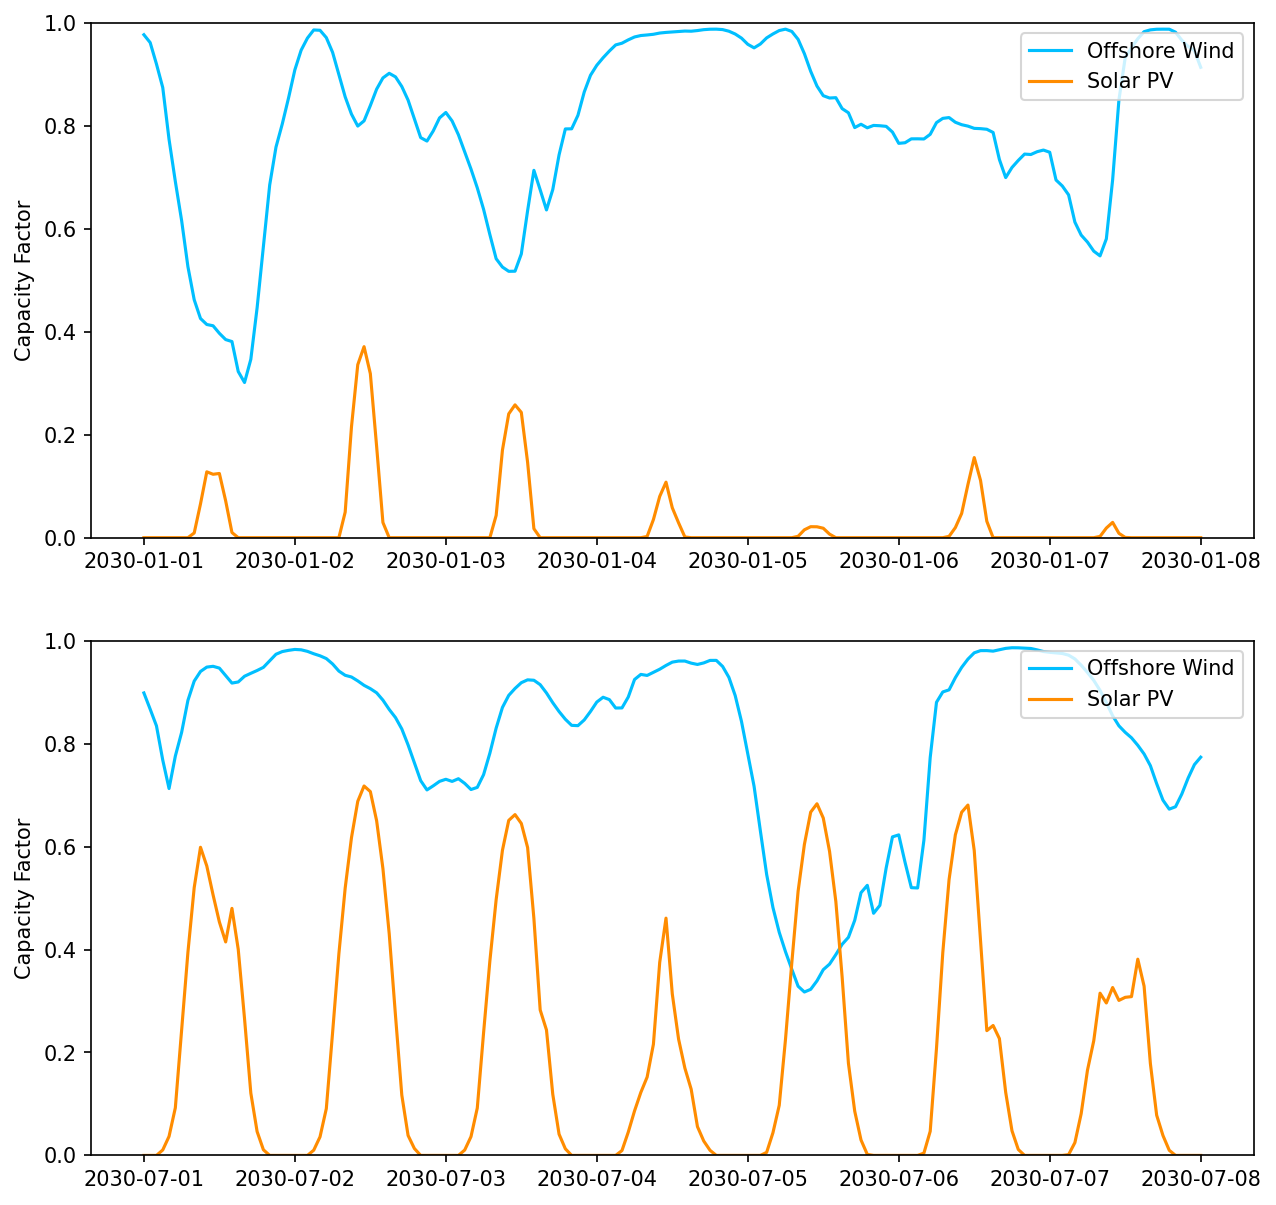

In [5]:
plt.figure(figsize = (10,10), dpi = 150)

plt.subplot(211)
plt.plot(cf['Offshore Wind']['%d-01-01 00:00'%switch['year']:'%d-01-08 00:00'%switch['year']],
         c = 'deepskyblue', label = 'Offshore Wind')
plt.plot(cf['Solar PV']['%d-01-01 00:00'%switch['year']:'%d-01-08 00:00'%switch['year']],
         c = 'darkorange', label = 'Solar PV')
plt.ylim(0, 1)
plt.ylabel('Capacity Factor')
plt.legend(loc = 'upper right')

plt.subplot(212)
plt.plot(cf['Offshore Wind']['%d-07-01 00:00'%switch['year']:'%d-07-08 00:00'%switch['year']],
         c = 'deepskyblue', label = 'Offshore Wind')
plt.plot(cf['Solar PV']['%d-07-01 00:00'%switch['year']:'%d-07-08 00:00'%switch['year']],
         c = 'darkorange', label = 'Solar PV')
plt.ylim(0, 1)
plt.ylabel('Capacity Factor')
plt.legend(loc = 'upper right')

plt.show()

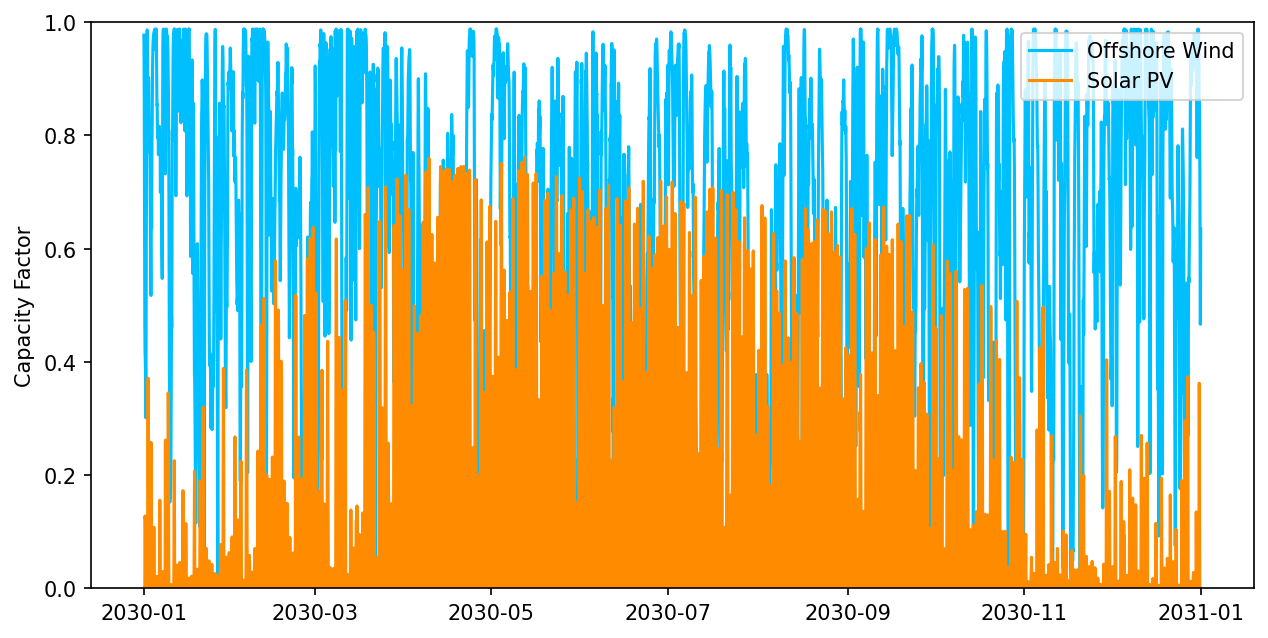

In [6]:
plt.figure(figsize = (10,5), dpi = 150)
plt.plot(cf['Offshore Wind'], c = 'deepskyblue', label = 'Offshore Wind')
plt.plot(cf['Solar PV'], c = 'darkorange', label = 'Solar PV')
plt.ylim(0, 1)
plt.ylabel('Capacity Factor')
plt.legend(loc = 'upper right')
plt.show()

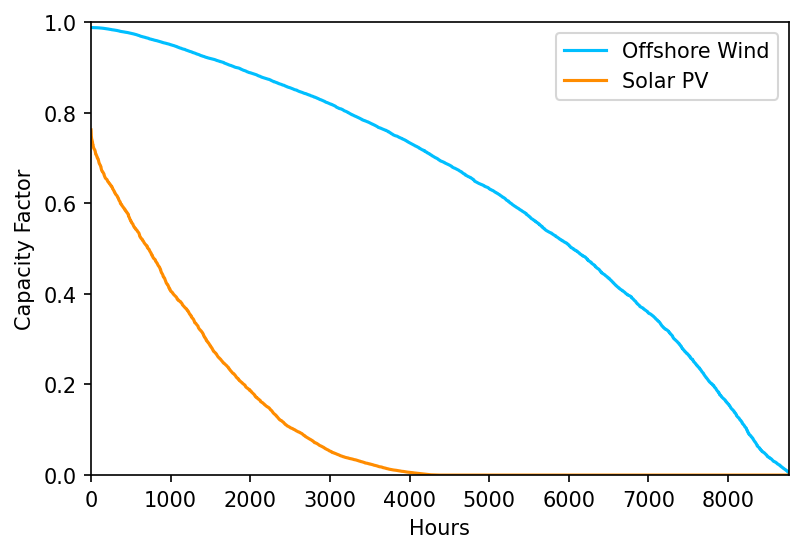

In [7]:
x = np.arange(np.shape(t)[0])
plt.figure(figsize = (6,4), dpi = 150)
plt.plot(x, cf['Offshore Wind'].sort_values(ascending = False), c = 'deepskyblue', label = 'Offshore Wind')
plt.plot(x, cf['Solar PV'].sort_values(ascending = False), c = 'darkorange', label = 'Solar PV')
plt.xlim(0, np.shape(t)[0]-1)
plt.ylim(0, 1)
plt.xlabel('Hours')
plt.ylabel('Capacity Factor')
plt.legend(loc = 'upper right')
plt.show()

In [8]:
# efficiency of fuel plants/engines
eff_link = pd.Series(index = ['H2 Plant','NH3 Plant'], dtype = float)
eff_link['H2 Plant'] = 1000*141.7*10**6/(50000*3.6*10**6)
eff_link['NH3 Plant'] = 1000*23*10**6/(9900*3.6*10**6)
eff_engine = pd.Series([0.55,0.38], index = ['H2','NH3'])

# wind: 21 large turbines, off-shore
# pv: large scale utility systems (NO axis-tracking)
# H2: AEC 100MW
# NH3: no electrolyzer, ASU ?
if switch['year'] == 2030:
    n = np.array([30,40,30,30]) # expected lifetime of 'Offshore Wind','Solar PV','H2 Plant','NH3 Plant'
    r = np.array([0.07]) # constant discount rate
    costdata = pd.DataFrame(np.array([[1.93*10**6,0.38*10**6,4.5*10**5,1.3*10**6], # €/MW
                                      [36053,7250,9000,39000], # €/(MW·year)
                                      [2.7,0.01,0.01,0.02]]), # €/MWh
                            index = ['Investment','FOM','VOM'],
                            columns = ['Offshore Wind','Solar PV','H2 Plant','NH3 Plant'])
elif switch['year'] == 2040: 
    n = np.array([30,40,32,30]) # expected lifetime of 'Offshore Wind','Solar PV','H2 Plant','NH3 Plant'
    r = np.array([0.07]) # constant discount rate
    costdata = pd.DataFrame(np.array([[1.81*10**6,0.33*10**6,3.0*10**5,1.1*10**6], # €/MW
                                      [33169,6625,6000,32000], # €/(MW·year)
                                      [2.5,0.01,0.01,0.02]]), # €/MWh
                            index = ['Investment','FOM','VOM'],
                            columns = ['Offshore Wind','Solar PV','H2 Plant','NH3 Plant'])
elif switch['year'] == 2050: 
    n = np.array([30,40,35,30]) # expected lifetime of 'Offshore Wind','Solar PV','H2 Plant','NH3 Plant'
    r = np.array([0.07]) # constant discount rate
    costdata = pd.DataFrame(np.array([[1.78*10**6,0.3*10**6,2.5*10**5,0.8*10**6], # €/MW
                                      [32448,6250,5000,24000], # €/(MW·year)
                                      [2.4,0.01,0.01,0.02]]), # €/MWh
                            index = ['Investment','FOM','VOM'],
                            columns = ['Offshore Wind','Solar PV','H2 Plant','NH3 Plant'])
ccost = annuity(n,r)*costdata.loc['Investment']+costdata.loc['FOM'] # €/MW

In [9]:
network = pypsa.Network()

network.set_snapshots(t)

network.add('Bus', 'Electricity')
network.add('Bus', 'H2')
network.add('Bus', 'NH3')

In [10]:
load = pd.Series(np.full(np.shape(t)[0], 0.05*1.9*10**6*10**12/(3.6*10**6)/1000/8760), # MWh
                 index = t)
network.add('Load',
            'Fuel Demand', 
            bus = switch['fuel'], 
            p_set = load)

network.add('Store',
            'Free Tank',
            bus = switch['fuel'],
            e_nom_extendable = True,
            e_cyclic = True,
            capital_cost = 0)

In [11]:
if switch['wind']:
    network.add('Generator',
                'Offshore Wind',
                bus = 'Electricity',
                p_nom_extendable = True,
                #p_nom_min = 2000,
                capital_cost = ccost['Offshore Wind'],
                marginal_cost = costdata.loc['VOM']['Offshore Wind'],
                p_max_pu = cf['Offshore Wind'])

if switch['solar']:
    network.add('Generator',
                'Solar PV',
                bus = 'Electricity',
                p_nom_extendable = True,
                #p_nom_min = 2000,
                capital_cost = ccost['Solar PV'],
                marginal_cost = costdata.loc['VOM']['Solar PV'],
                p_max_pu = cf['Solar PV'])

In [12]:
network.add('Link',
            'H2 Plant', 
            bus0 = 'Electricity',
            bus1 = 'H2',
            p_nom_extendable = True,
            #p_nom_min = 2000,
            efficiency = eff_link['H2 Plant'],
            capital_cost = ccost['H2 Plant'],
            marginal_cost = costdata.loc['VOM']['H2 Plant'])

network.add('Link',
            'NH3 Plant', 
            bus0 = 'Electricity',
            bus1 = 'NH3',
            p_nom_extendable = True,
            #p_nom_min = 2000,
            efficiency = eff_link['NH3 Plant'],
            capital_cost = ccost['NH3 Plant'],
            marginal_cost = costdata.loc['VOM']['NH3 Plant'])

In [13]:
if switch['battery']:
    network.add('StorageUnit',
                'Battery',
                bus = 'Electricity',
                cyclic_state_of_charge = True,
                marginal_cost = 0, # in €/MWh_el (Assumed to zero)
                capital_cost = annuity(15,0.07)*144600, # in €/MW 
                p_nom_extendable = True,
                #p_nom_min = 2000,
                efficiency_store = 0.9, # Efficiency of storage on the way into the storage.
                efficiency_dispatch = 0.9, # Efficiency of storage on the way out of the storage.
                standing_loss = 0.01, # Losses per hour to state of charge.
                max_hours = 6) # Maximum state of charge capacity in terms of hours at full output capacity p_nom

In [14]:
# Countries
if switch['connection']:
    for i in country.keys():
        if country[i]:
            network.add('Bus', '%s'%i)
            mcost = pd.read_csv('data/market/price_%d_%s.csv'%(switch['year'],i), index_col = 0)
            mcost.index = t
            load = pd.read_csv('data/market/load_%d_%s.csv'%(switch['year'],i), index_col = 0)
            load.index = t
            network.add('Generator',
                        'Elec_%s'%i,
                        bus = '%s'%i,
                        p_nom_extendable = True,
                        marginal_cost = mcost[i])
            network.add('Load',
                        'Load_%s'%i, 
                        bus = '%s'%i, 
                        p_set = load[i])
            network.add('Link',
                        '%s to Energy Island'%i, 
                        bus0 = 'Electricity',
                        bus1 = '%s'%i,
                        p_nom_extendable = True,
                        efficiency = 1,
                        p_min_pu = -1,
                        capital_cost = (annuity(40,0.07)+0.02)*(2000*distance[i]+150000), # marta
                        marginal_cost = 0)

In [15]:
network.lopf(network.snapshots,
             #pyomo = False,
             solver_name = 'gurobi')

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x78847_copy
  Lower bound: 2471197109.937935
  Upper bound: 2471197109.937935
  Number of objectives: 1
  Number of constraints: 157681
  Number of variables: 78847
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 78847
  Number of nonzeros: 319681
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

In [16]:
network.objective/network.loads_t.p.sum() # €/MWh

Fuel Demand    93.645364
dtype: float64

In [17]:
network.objective/(network.loads_t.p.sum()*eff_engine[switch['fuel']]) # €/MWh

Fuel Demand    246.435169
dtype: float64

In [18]:
network.generators.p_nom_opt # in MW

Offshore Wind    6753.822529
Solar PV         5180.288300
Name: p_nom_opt, dtype: float64

In [19]:
network.links.p_nom_opt # in MW

H2 Plant        0.00000
NH3 Plant    5989.90139
Name: p_nom_opt, dtype: float64

In [20]:
network.links_t.p0

,H2 Plant,NH3 Plant
2030-01-01 00:00:00,0.0,5989.901390
2030-01-01 01:00:00,0.0,5989.901390
2030-01-01 02:00:00,0.0,5989.901390
2030-01-01 03:00:00,0.0,5989.901390
2030-01-01 04:00:00,0.0,5989.901390
...,...,...
2030-12-31 19:00:00,0.0,5586.953332
2030-12-31 20:00:00,0.0,5186.583353
2030-12-31 21:00:00,0.0,4467.108318
2030-12-31 22:00:00,0.0,3758.045986
